<b> Title: </b> Group 11 Final Project Report - DSCI 100 002 

<b> Group members: </b> Katie Archer, Noor Naila Imtinan Himam, Matthew Yeung, Wenwen Zhao

<b>1. Introduction</b>
<br>
According to scientific research, pulsars are an uncommon form of neutron stars that emit regular pulses of radiation, varying from several seconds to milliseconds in frequency. The potent magnetic fields of these stars generate intense beams of light at both poles. These beams are periodically observed as the pulsar rotates quickly, and they can only be observed with large telescopes when they cross our line of sight from Earth (National Aeronautics and Space Administration, n.d.)

Although pulsars emit a pattern of radio emission that can be detected as they rotate, it can be challenging to distinguish between genuine signals and background noise. Pulsar candidates are being classified as binary classification issues using machine learning tools. The HTRU 2 dataset, which is used to train classification models, includes examples of both real and fake pulsar signals. The class labels used are 0 (negative) and 1 (positive), with the legitimate pulsar examples being the minority positive class. The eight continuous variables are obtained from the integrated pulse profile and the DM-SNR (Disperion Measure - Signal-to-Noise Ratio) curve, which describe the longitude-resolved version of the signal averaged in both time and frequency (Keith et al., 2010). Each candidate in the dataset is described by eight continuous variables, one class variable, and no astronomical information. The integrated pulse profile and the DM-SNR curve are used to determine the eight variables.

In this project, we aim to figure out if information from the integrated pulse profile and DM-SNR curve of pulsar candidates can be used to classify whether signals are legitimate or spurious (real or fake pulsar) with high accuracy, and if so, which predictors will lead to the greatest accuracy.

<b>2. Preliminary exploratory data analysis:</b>


load libraries

In [23]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(GGally)
install.packages("corrplot")
library(corrplot)
library(RColorBrewer)   
library(class)          
library(e1071)          
library(stringr)
set.seed(1)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

corrplot 0.92 loaded


Attaching package: ‘e1071’


The following object is masked from ‘package:tune’:

    tune


The following object is masked from ‘package:rsample’:

    permutations


The following object is masked from ‘package:parsnip’:

    tune




<b>Summarize the data in at least one table </b>

clean and preview dataset

In [24]:
options(repr.matrix.max.rows = 10)

pulsar_data <- read_csv("pulsar_data.csv", col_names = c("mean_integrated_profile", "stand_dev_integrated_profile", "exc_kurtosis_integrated_profile", "skew_integrated_profile",
                  "mean_dmsnr", "stand_dev_dmsnr", "exc_kurtosis_dmsnr", "skew_dmsnr", "class"))
pulsar_data <- pulsar_data |> drop_na()
head(pulsar_data)


Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_integrated_profile,stand_dev_integrated_profile,exc_kurtosis_integrated_profile,skew_integrated_profile,mean_dmsnr,stand_dev_dmsnr,exc_kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


#Dataset Exploration Graph 1 (correlation)

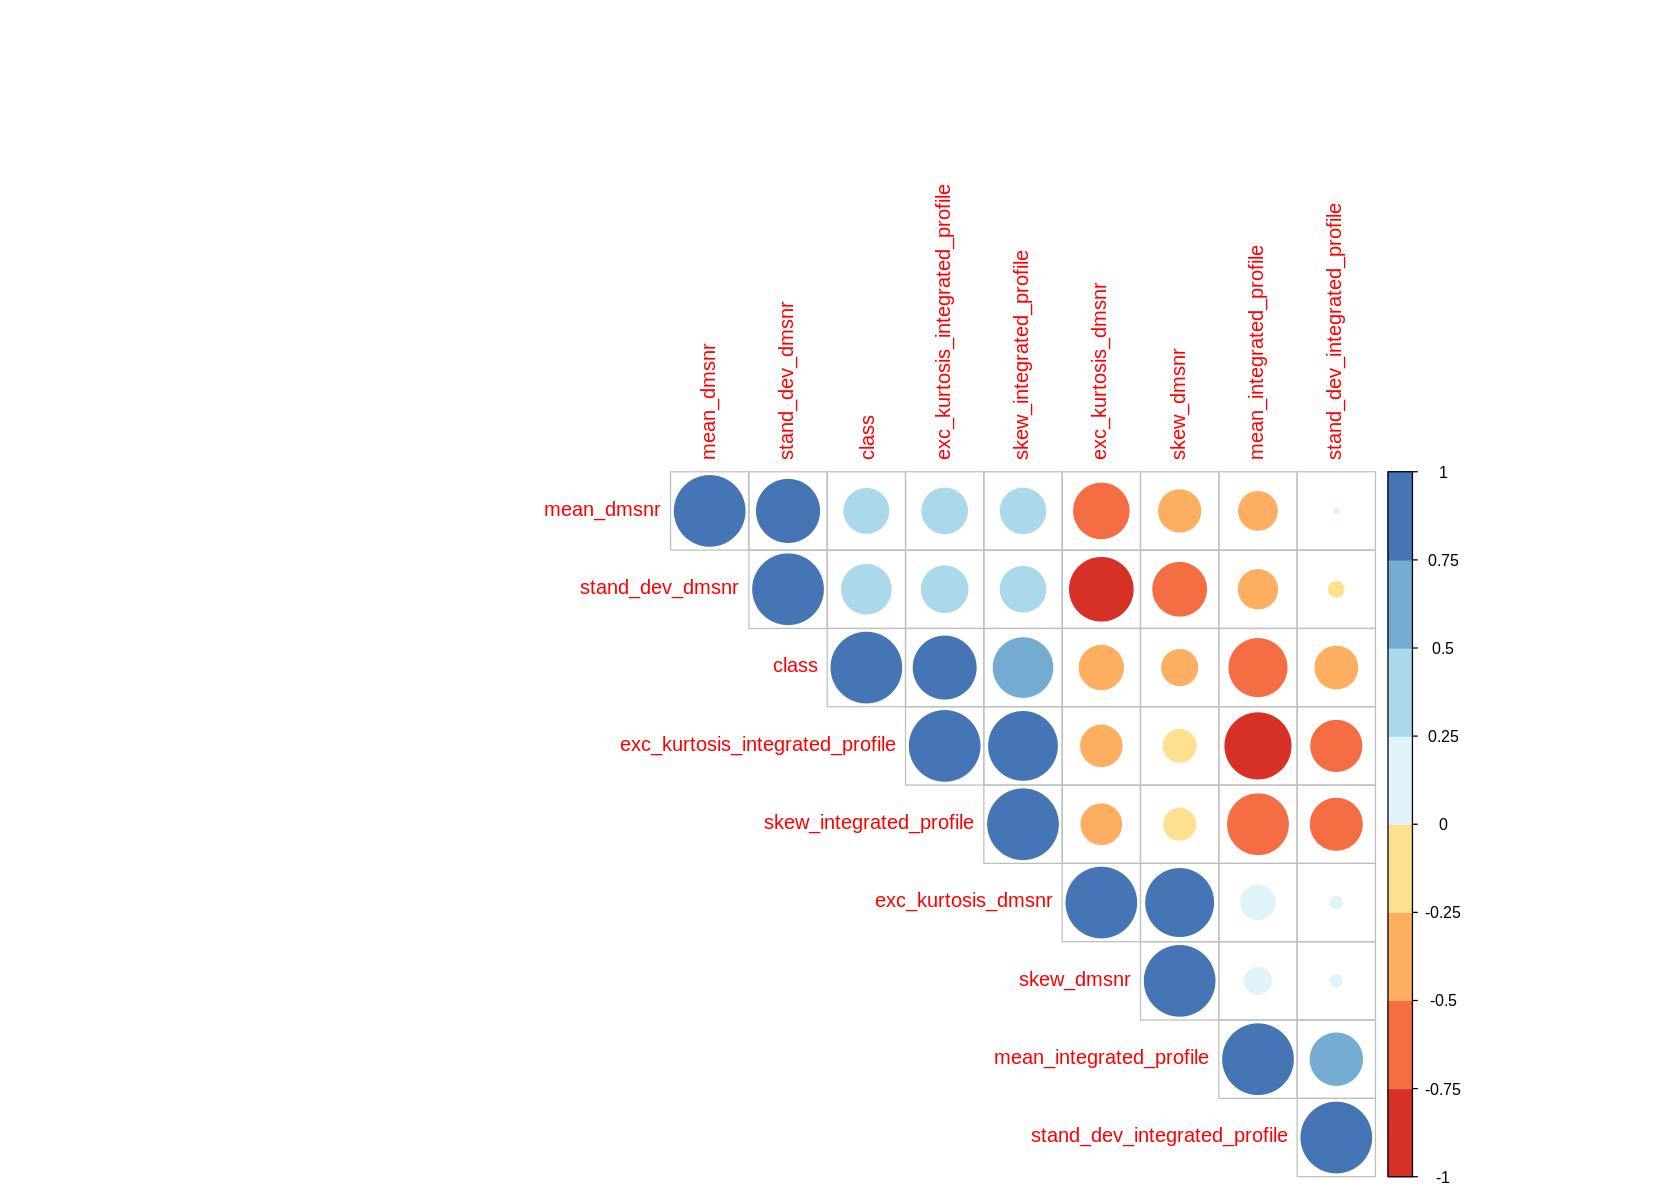

In [25]:
cor_pulse <- cor(pulsar_data)
corrplot(cor_pulse, type="upper", order="hclust",col=brewer.pal(n=8, name="RdYlBu"))

We can see that there is a different correlation value between the variables where some of them are high value 

#Dataset Exploration Graph 2 (variable distribution)

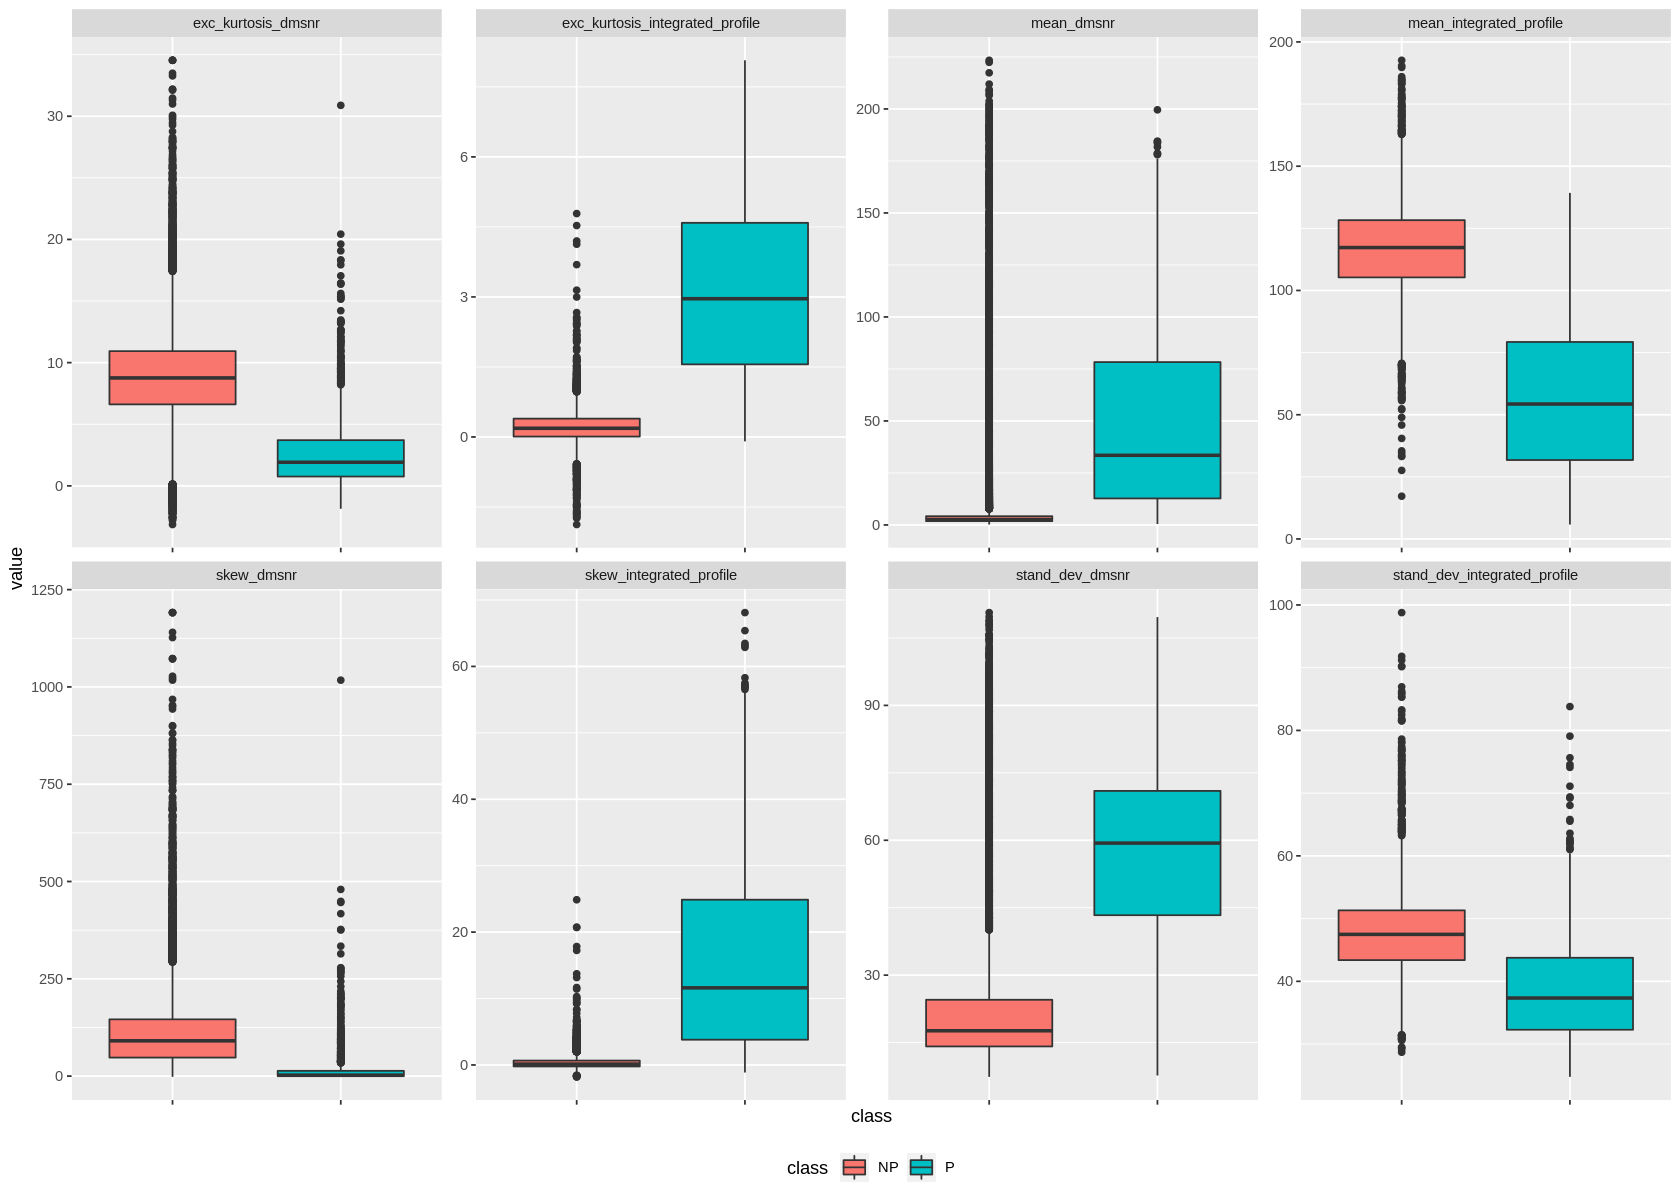

In [26]:
pulsar_data$class <- ifelse(pulsar_data$class == 1, "P", "NP")

pulsar_data |> gather(predictors, value, -class) %>%
  ggplot(aes(class, value, fill = class)) +
  geom_boxplot() +
  facet_wrap(~predictors, scales = "free", ncol = 4) +
  theme(axis.text.x = element_blank(), legend.position="bottom")

As shown above, the distribution graph above shows that some of the variable's value shows an evident differnce between pulsar and fake pulsar 

Now, we will see the proportion of pulsar and non pulsar dataset to determine a data balancing method

In [31]:
prop.table(table(pulsar_data$class))


        NP          P 
0.90842552 0.09157448 

In [32]:
table(pulsar_data$class)


   NP     P 
16259  1639 

rare_pulsar <- bind_rows(
      filter(pulsar_data, class == "P"),
      pulsar_data |> filter(class == "NP") |> slice_head(n = 3)
    ) |>
    select(class, skew_integrated_profile, skew_dmsnr)

rare_plot <- rare_pulsar |>
  ggplot(aes(x = skew_integrated_profile, y = skew_dmsnr, color = class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Skew Integrated Profile (standardized)", 
       y = "Skew dmsnr (standardized)",
       color = "Diagnosis") +
  scale_color_manual(labels = c("Pulsar", "Non Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

rare_plot

As we can see from the proportion and plot, we have to balance the train data set. Otherwise we will not learn correctly. Indeed, the algorithm will not have enough information about Pulsar Star.

For the present purposes, it will suffice to rebalance the data by oversampling the rare class. In other words, we will duplicate randomly observations of class 1 until we have the same number of class 0 and class 1

<b>Methods </b>

General steps:
1. Standardize values of skewness of the integrated profile and DM-SNR curve to use as predictors, will predict for class
2. Split training set further, perform 5-fold cross validation to determine best K-value
3. Build classification model, train entire training set with the best K-value
4. Predict on the testing set, assess model's accuracy by collecting metrics and creating visualizations

One way that we will visualize our results is through a scatter plot with the predictor variables on the x- and y- axes and each point representing an observation in the testing set. We will colour code the points by class, in terms of whether or not our model classified them correctly. We will use 4 colours; one to indicate that an observation was predicted correctly as a real pulsar, one to indicate that an observation was predicted correctly as a false pulsar, one to indicate that an observation was predicted incorrectly as a real pulsar when in the testing set it was labelled as fake, and a final one to indicate that an observation was predicted incorrectly as a false pulsar when in fact it was real as labelled in the testing set. This will give a visual of how accurate the model was, and for which values of the standardized predictors the model had the most trouble classifying candidates correctly.


<b>Data Analysis and Results </b>

First, we install a package that will allow us to upsample our dataset, and load the libraries we will need for our data analysis.

In [2]:
#CAUTION: Takes a long time to load.
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(RColorBrewer)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Next, we read in our data. Upon inspection, we see that the percanetage of observations corresponding to real pulsars is around 9%. To balance the proportion of real pulsar observations to false pulsar observations, we upsample the dataset (i.e. create more real pulsar observations that have predictor values similar to those in the original dataset). We also scale and center our 6 predictor values as part of preprocessing the data.

In [4]:
#Add columns
unscaled_data <- read_csv("pulsar_data.csv", 
                        col_names = c("mean_integrated_profile", 
                                      "stand_dev_integrated_profile", 
                                      "exc_kurtosis_integrated_profile", 
                                      "skew_integrated_profile",
                                      "mean_dmsnr", 
                                      "stand_dev_dmsnr", 
                                      "exc_kurtosis_dmsnr", 
                                      "skew_dmsnr", "class")) 

unscaled_data <- unscaled_data |>
    drop_na() |>
    mutate(class = as_factor(class))
#unscaled_data 

#Class proportions in pulsar dataset (Imbalanced)
num_obs <- nrow(unscaled_data)
pulsar_proportions <- unscaled_data |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(unscaled_data))
pulsar_proportions

#Scale data and Upsample to balance data
pulsar_recipe <- recipe(class ~ exc_kurtosis_integrated_profile + skew_dmsnr + stand_dev_integrated_profile + 
                        mean_dmsnr + skew_integrated_profile + exc_kurtosis_dmsnr, data = unscaled_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(class, over_ratio = 1, skip = FALSE) |>
    prep()

standardized_pulsar <- bake(pulsar_recipe, unscaled_data)
standardized_pulsar

#check proportions of upsampled data
new_pulsar_proportions <- standardized_pulsar |>
    group_by(class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(standardized_pulsar))
new_pulsar_proportions

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_integrated_profile, stand_dev_integrated_profile, exc_kurtosis...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,n,percent
<fct>,<int>,<dbl>
0,16259,90.842552
1,1639,9.157448


exc_kurtosis_integrated_profile,skew_dmsnr,stand_dev_integrated_profile,mean_dmsnr,skew_integrated_profile,exc_kurtosis_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.66955083,-0.2874301,1.3347944,-0.3194313,-0.4004478,-0.07279575,0
-0.01178443,0.2115755,1.8022150,-0.3710915,-0.3705251,0.50441285,0
-0.14522850,-0.3913625,-1.0532928,-0.3220980,-0.1165896,-0.12599257,0
-0.51339427,-0.4812869,1.5532110,-0.3043957,-0.3901672,-0.31225666,0
0.11560548,1.3867553,-0.8588548,-0.3879995,-0.1048632,1.32398915,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2.4687601,-0.6151872,-1.30476244,-0.2491326,1.88399474,-0.4902266,1
0.6165649,-0.9861004,0.03305275,1.2900344,0.01428139,-1.5796051,1
4.5684494,-0.9888337,-1.72832447,4.0472016,4.32109541,-1.8490743,1


class,n,percent
<fct>,<int>,<dbl>
0,16259,50
1,16259,50


Here, we split our preproceesed data into training and testing sets, and put 75% of the data into the training set. We also build our recipe given our chosen predictors. 

In [12]:
set.seed(1)
pulsar_split <- initial_split(standardized_pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split) 

pulsar_recipe <- recipe(class ~ exc_kurtosis_integrated_profile+skew_dmsnr+stand_dev_integrated_profile+mean_dmsnr, data = pulsar_train)
pulsar_recipe

#pulsar_prediction_accuracy <- pulsar_test_predictions |>
  #  metrics(truth = class, estimate = .pred_class) |>
 #   filter(.metric == "accuracy")
#pulsar_prediction_accuracy

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Now we perform cross validation on the training set in order to select the best K value for our classifier (number of neighbors). To do this, we use 10 folds. But first, we build a classification model that specifies that we want to tune the number of neighbors. We create a tibble that contains each K value that we want to test.

In [13]:
#build the model, CAUTION: Takes a long time to load.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#Create a tibble for the K values
k_vals <- tibble(neighbors = seq(from = 1, to = 75, by = 3))
#k_vals

#Set up and perform 10 fold cross validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 10, strata = class)

knn_results <- workflow() |>
               add_recipe(pulsar_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
               collect_metrics() #assess the accuracy 
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9895445,10,0.0006018861,Preprocessor1_Model01
1,roc_auc,binary,0.9895445,10,0.0006018861,Preprocessor1_Model01
4,accuracy,binary,0.9818360,10,0.0010049520,Preprocessor1_Model02
4,roc_auc,binary,0.9897002,10,0.0006188308,Preprocessor1_Model02
7,accuracy,binary,0.9651474,10,0.0008701912,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
67,roc_auc,binary,0.9804432,10,0.0007039644,Preprocessor1_Model23
70,accuracy,binary,0.9421433,10,0.0016479828,Preprocessor1_Model24
70,roc_auc,binary,0.9801160,10,0.0007175367,Preprocessor1_Model24


To determine the best K to use, we filter the collected metrics from cross validation and plot the accuracy against the K values we tested.

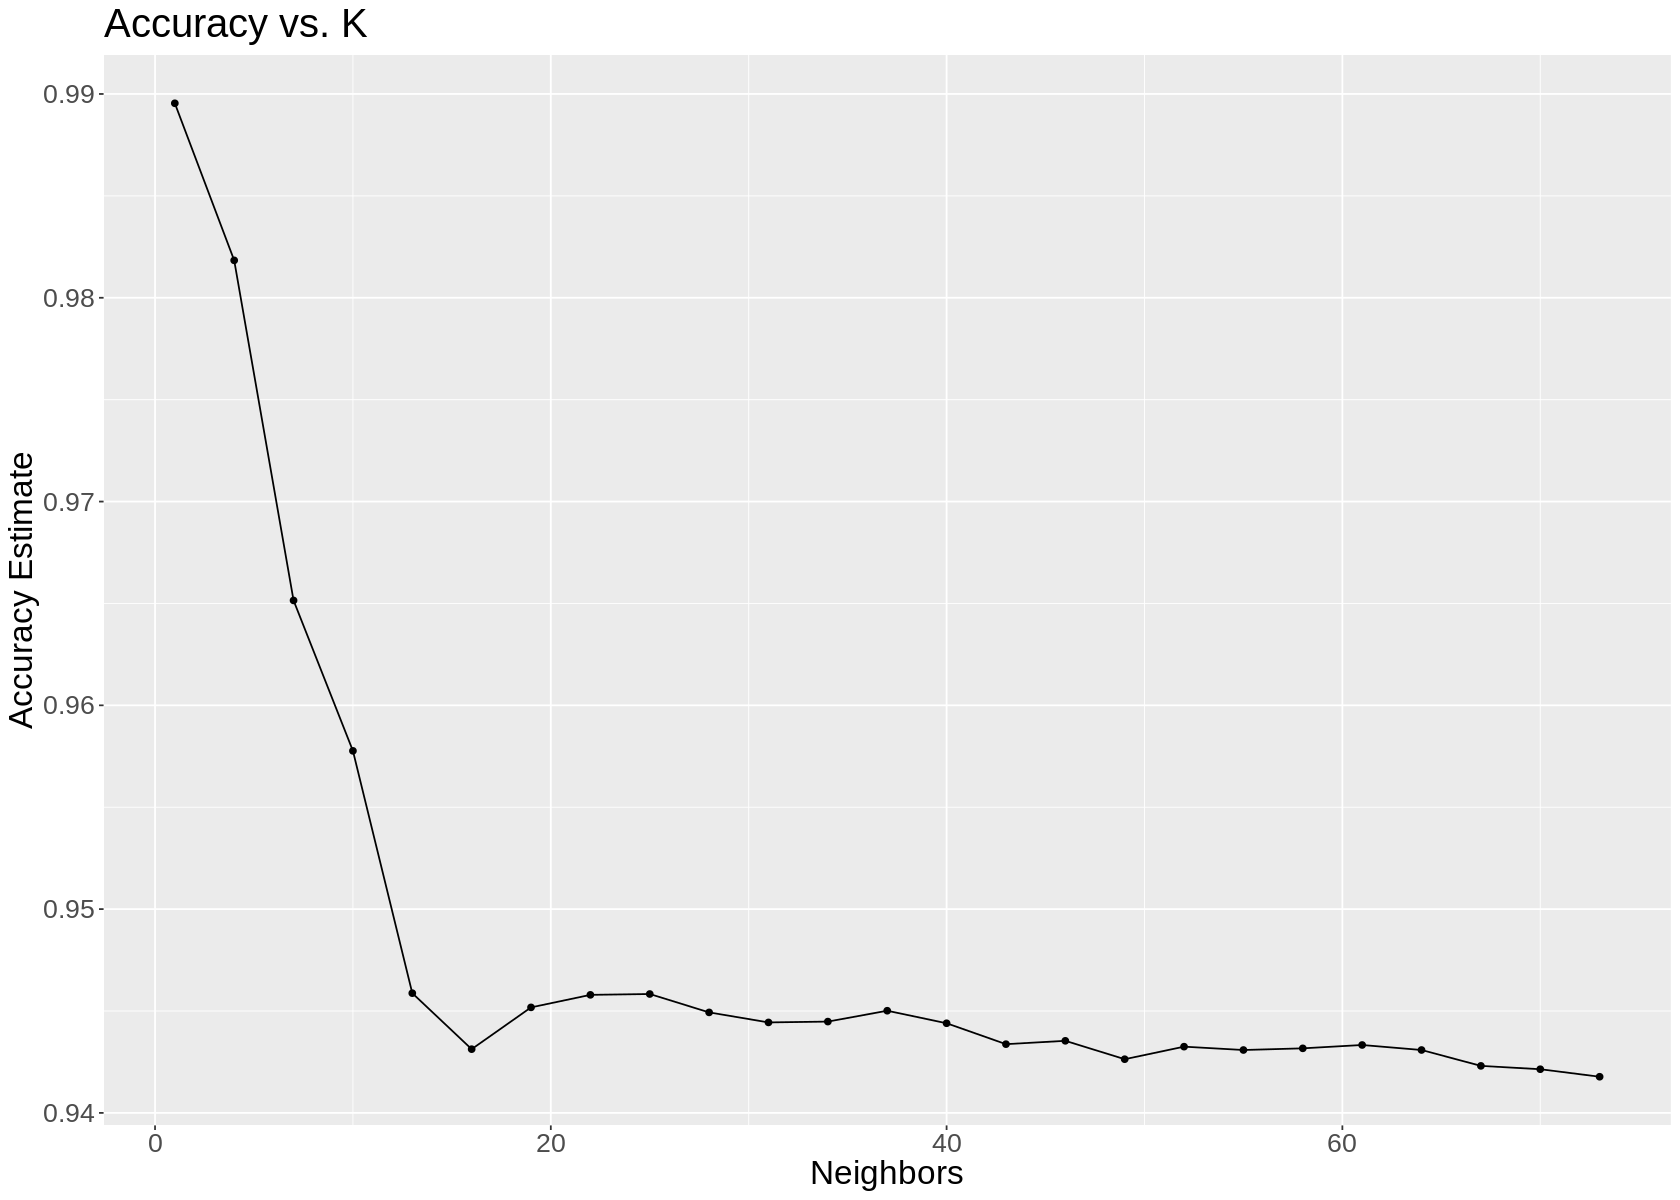

In [14]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       ggtitle("Accuracy vs. K") +
       theme(text = element_text(size = 20))
accuracy_versus_k

Based on the above plot, we see that the accuracy decreases quite steeply as the number of neighbors increases, before leveling off from around K = 16 onwards. We choose K = 17 for our classification model because the accuracy is high at this point, and the accuracy does not change drastically when looking at similar K values. Overall, we want to avoid overfitting the data by selecting too few neighbors, and 17 is an odd number (given that K-nearest neighbors classifies observations based on a majority rules system, using an even number of neighbors could be problematic in the event of a tie, since our class variable is binary). 

Upon determining the optimal K value for our classifier, we can finally predict on our testing set. As done below, we use the same recipe as before, but a new model that sets the number of neighbors to 17 must be built. Once we have used the model to predict the classes of the observations in the test set, we take a confusion matrix to view the accuracy.

In [15]:
knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
                    set_engine("kknn") |>
                    set_mode("classification")

pulsar_fit_final <- workflow() |>
        add_recipe(pulsar_recipe) |>
        add_model(knn_spec_final) |>
        fit(data = pulsar_train)

pulsar_test_predictions_final <-  predict(pulsar_fit_final, pulsar_test) |>
        bind_cols(pulsar_test)

pulsar_test_predictions_final                

confusion_final <- pulsar_test_predictions_final |>
    conf_mat(truth = class, estimate = .pred_class)
confusion_final

.pred_class,exc_kurtosis_integrated_profile,skew_dmsnr,stand_dev_integrated_profile,mean_dmsnr,skew_integrated_profile,exc_kurtosis_dmsnr,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,-0.66955083,-0.2874301,1.3347944,-0.3194313,-0.4004478,-0.07279575,0
0,-0.01178443,0.2115755,1.8022150,-0.3710915,-0.3705251,0.50441285,0
0,-0.75014651,-0.6292692,-0.1843379,-0.2455865,-0.2409772,-0.49428426,0
0,-0.52527844,0.8513931,-0.3640536,-0.3726235,-0.2683108,0.81412244,0
0,-0.31974505,1.1132819,0.3606682,-0.3768221,-0.3286328,1.12389396,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1.00370953,-0.9084894,0.17595126,0.2903347,0.20988638,-1.1945147,1
0,-0.01684165,-0.6109620,-1.21243027,-0.2775301,-0.01290392,-0.5245807,1
1,2.46876014,-0.6151872,-1.30476244,-0.2491326,1.88399474,-0.4902266,1


          Truth
Prediction    0    1
         0 3821  246
         1  244 3819

To visualize the accuracy of our classification model, we create a new column in the predictions table that will allow us to visualze the test data in such a way that colour-coding the observations will let us see the information stored in the confusion matrix. (***not worded very well)

In [16]:
mutated_predictions <- pulsar_test_predictions_final |>
    mutate(new_cat = case_when(.pred_class == 0 & class == 0 ~ "False pulsar, correctly classified",
                               .pred_class == 1 & class == 1 ~ "Real pulsar, correctly classified",
                               .pred_class == 1 & class == 0 ~ "False pulsar, incorrectly classified",
                               .pred_class == 0 & class == 1 ~ "Real pulsar, incorrectly classified"))
mutated_predictions

#this code came from: https://community.rstudio.com/t/creating-a-new-variable-under-conditions-of-other-two-variables/51825 

.pred_class,exc_kurtosis_integrated_profile,skew_dmsnr,stand_dev_integrated_profile,mean_dmsnr,skew_integrated_profile,exc_kurtosis_dmsnr,class,new_cat
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,-0.66955083,-0.2874301,1.3347944,-0.3194313,-0.4004478,-0.07279575,0,"False pulsar, correctly classified"
0,-0.01178443,0.2115755,1.8022150,-0.3710915,-0.3705251,0.50441285,0,"False pulsar, correctly classified"
0,-0.75014651,-0.6292692,-0.1843379,-0.2455865,-0.2409772,-0.49428426,0,"False pulsar, correctly classified"
0,-0.52527844,0.8513931,-0.3640536,-0.3726235,-0.2683108,0.81412244,0,"False pulsar, correctly classified"
0,-0.31974505,1.1132819,0.3606682,-0.3768221,-0.3286328,1.12389396,0,"False pulsar, correctly classified"
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1.00370953,-0.9084894,0.17595126,0.2903347,0.20988638,-1.1945147,1,"Real pulsar, correctly classified"
0,-0.01684165,-0.6109620,-1.21243027,-0.2775301,-0.01290392,-0.5245807,1,"Real pulsar, incorrectly classified"
1,2.46876014,-0.6151872,-1.30476244,-0.2491326,1.88399474,-0.4902266,1,"Real pulsar, correctly classified"


Visualization of our classifier's accuracy:

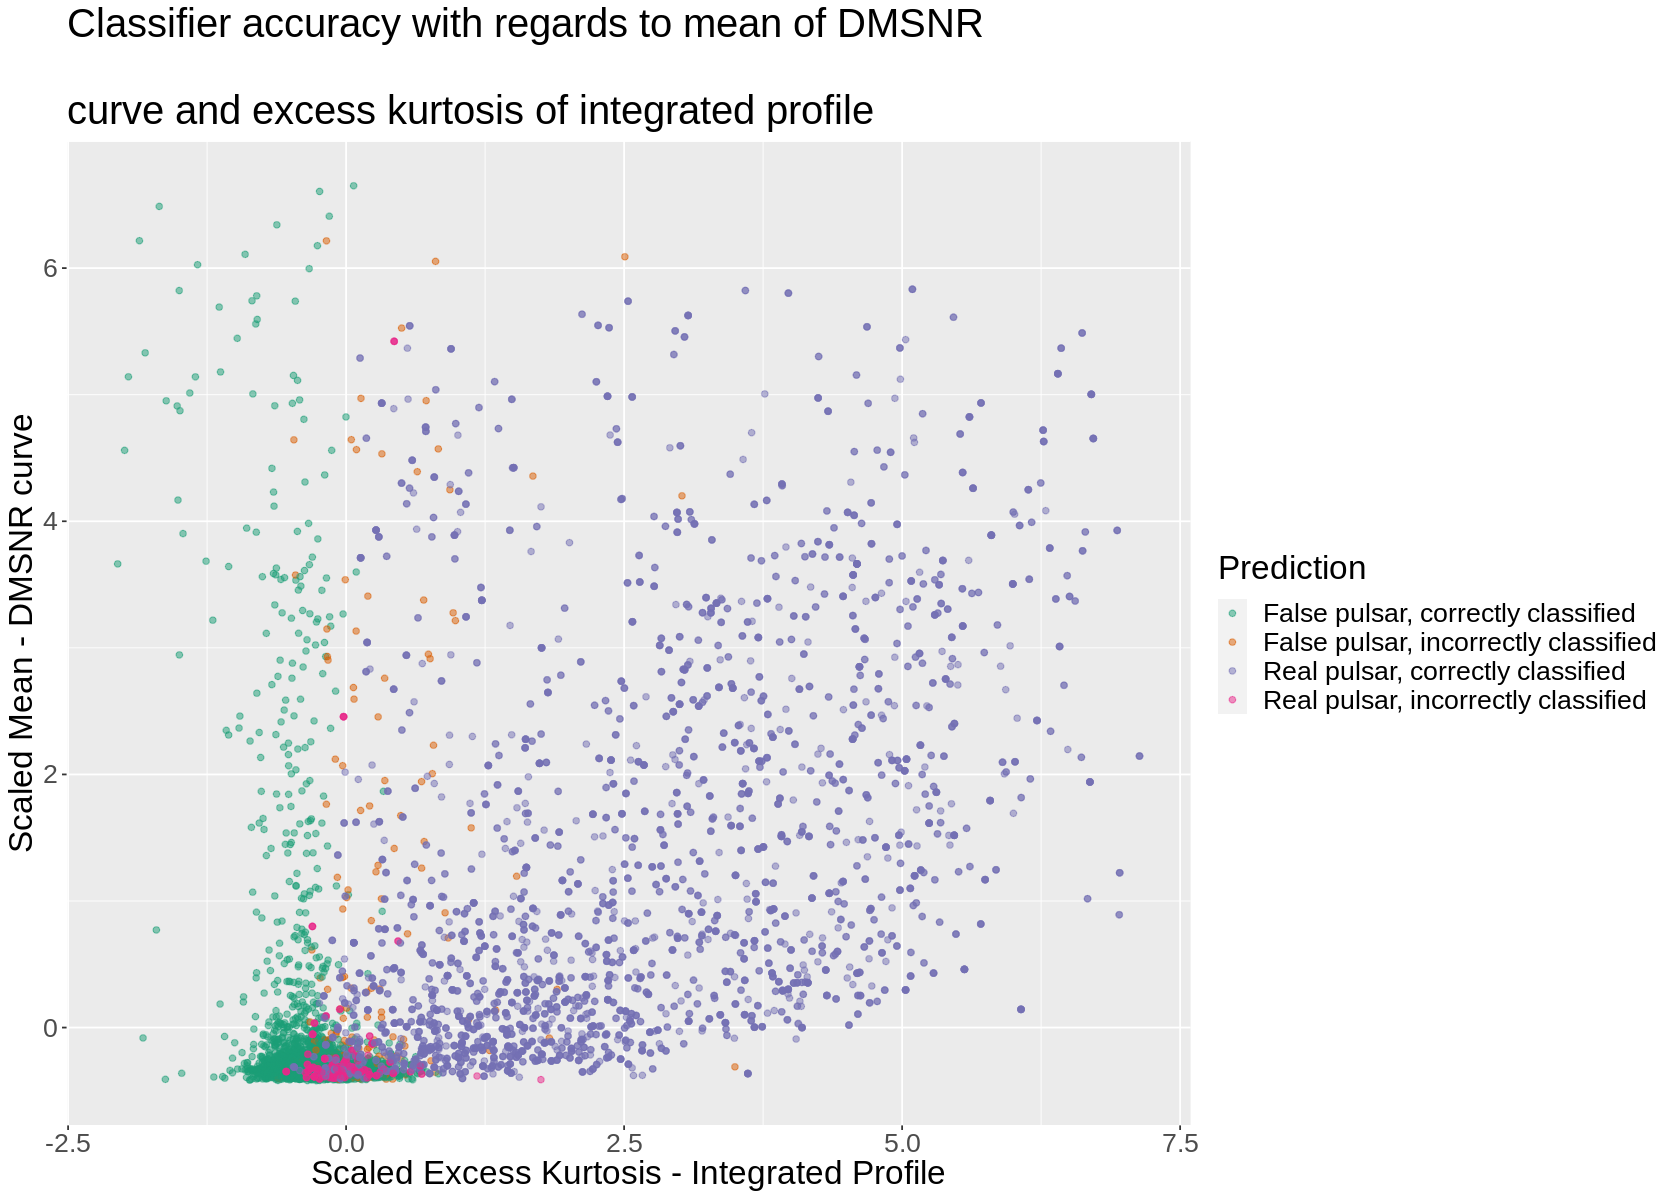

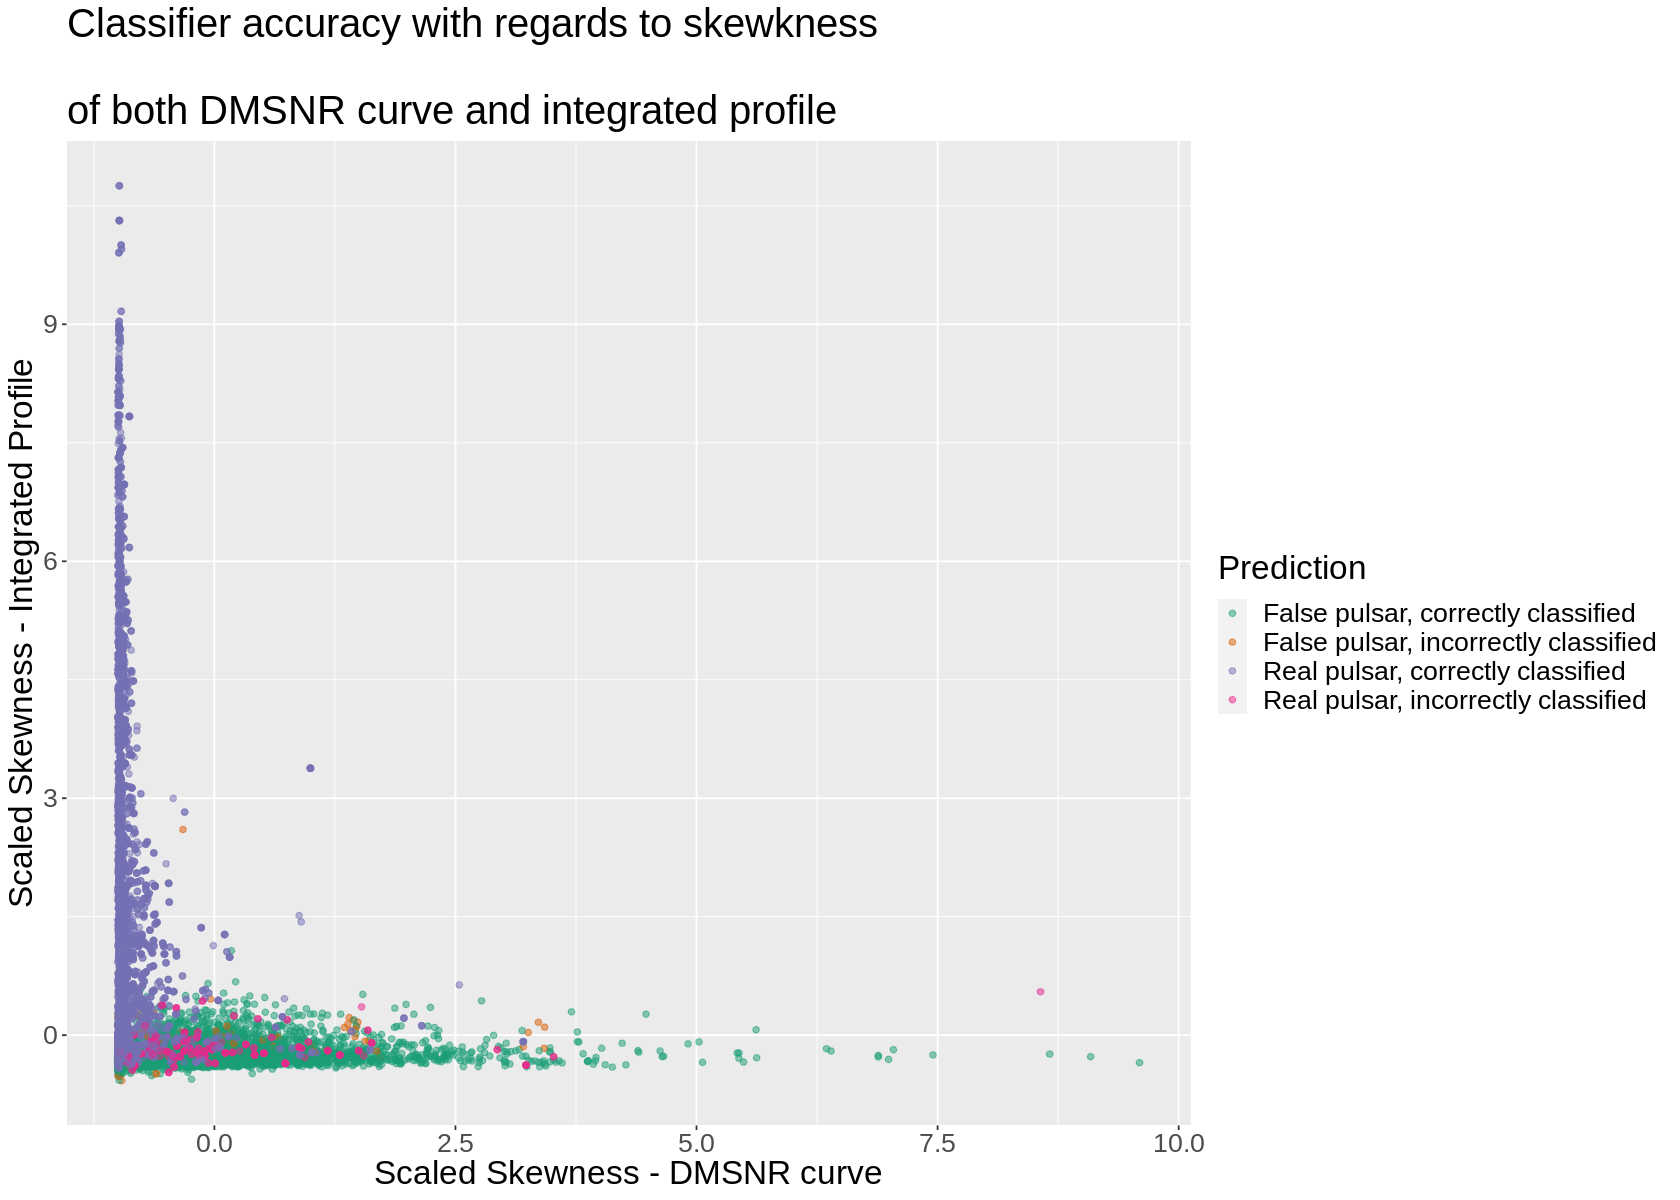

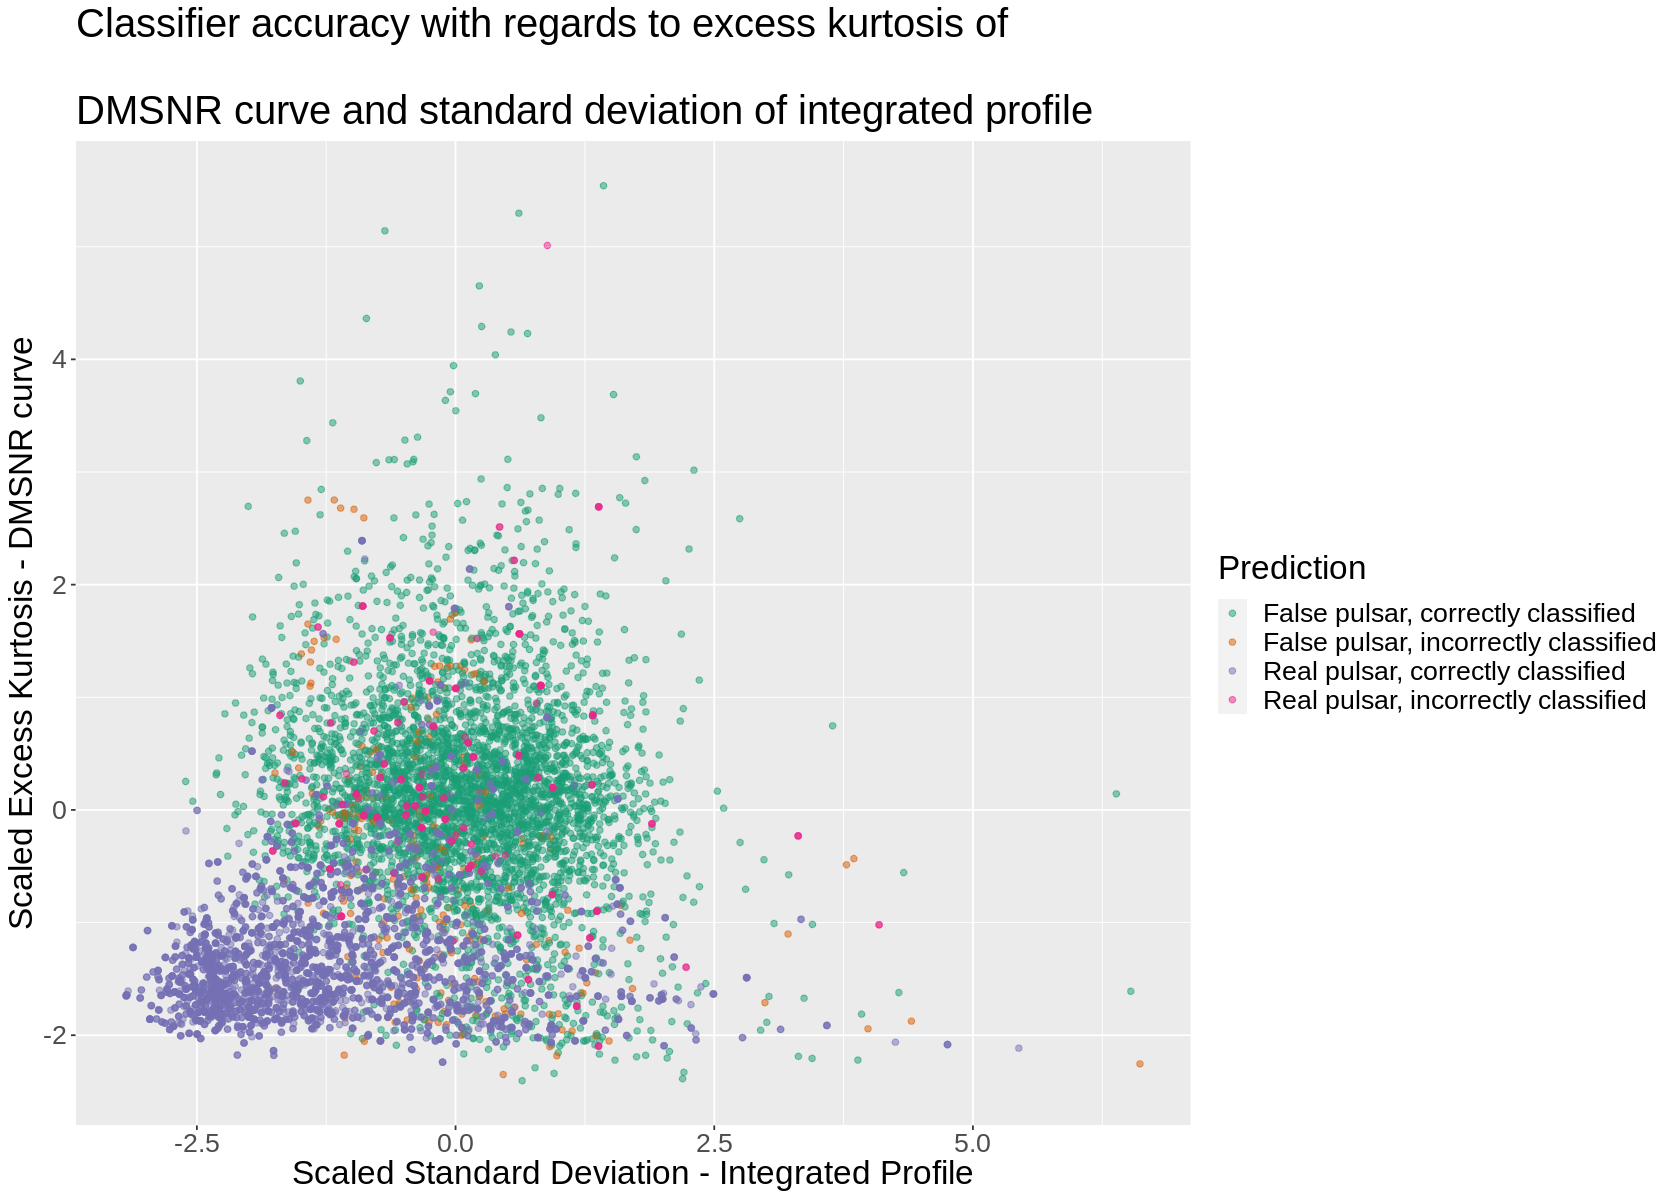

In [17]:
options(repr.plot.height = 10, repr.plot.width = 14)

#First 2 predictors
plot_1 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = exc_kurtosis_integrated_profile, 
                                                              y = mean_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Excess Kurtosis - Integrated Profile", y = "Scaled Mean - DMSNR curve", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to mean of DMSNR
                \ncurve and excess kurtosis of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_1



#Next 2 predictors
plot_2 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = skew_dmsnr,
                                                              y = skew_integrated_profile, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Skewness - DMSNR curve", y = "Scaled Skewness - Integrated Profile", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to skewkness
                \nof both DMSNR curve and integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_2



#Last 2 predictors
plot_3 <- ggplot() +
    geom_point(data = mutated_predictions, mapping = aes(x = stand_dev_integrated_profile, 
                                                             y = exc_kurtosis_dmsnr, colour = new_cat), alpha = 0.5) +
    labs(x = "Scaled Standard Deviation - Integrated Profile", y = "Scaled Excess Kurtosis - DMSNR curve", colour = "Prediction") +
    ggtitle("Classifier accuracy with regards to excess kurtosis of
                \nDMSNR curve and standard deviation of integrated profile") +
    scale_color_brewer(palette = "Dark2") +
    theme(text = element_text(size = 20))
plot_3

As can be seen above, there are very few observations in the testing set that were incorrectly classified. This indicates that our model is quite accurate. We can represent the accuracy of our model as a percentage, as well:

In [18]:
#From the confusion matrix:

accuracy_perc <- ((3838 + 3853)/8130)*100
accuracy_perc

[1] 94.60025

Therefore, <b> ~95% </b> is a good estimate of how accuracte our classication model is.

<b>Discussion </b>

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

**References**

Dr Robert Lyon, University of Manchester, School of Physics and Astronomy, Alan Turing Building, Manchester M13 9PL, United Kingdom, robert.lyon '@' manchester.ac.uk

Keith, M. J., et al. (2010). The HTRU survey. Handbook of pulsar astronomy, 379-422.

United States. National Aeronautics and Space Administration. NASA technical note. Washington :National Aeronautics and Space Administration.